<a href="https://colab.research.google.com/github/Pratik1999/tmp/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression


from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


import os

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
VALIDATION_SPLIT = 0.2

In [ ]:
imdb_data=pd.read_csv('/content/drive/MyDrive/movie_data.csv',error_bad_lines=False)

In [ ]:
imdb_data.shape

(50000, 2)

In [ ]:
imdb_data.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [ ]:
imdb_data.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


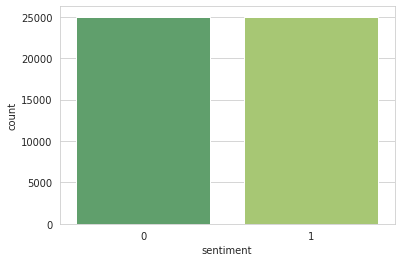

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=imdb_data, palette='summer')

# Text Preprocessing

In [ ]:
def remove_whitespace(text):
    return  " ".join(text.split())

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def remove_stopwords(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = " ".join([word for word in word_tokens if word not in stop_words])
    return filtered_text

def process_text(text):
  text=remove_whitespace(text)
  text=strip_html(text)
  text=remove_between_square_brackets(text)
  text=remove_special_characters(text)
  text=remove_stopwords(text)
  
  return text


In [ ]:
imdb_data['review']=imdb_data['review'].apply(process_text)

In [ ]:
imdb_data.head()

,review,sentiment
0,In 1974 teenager Martha Moxley Maggie Grace mo...,1
1,OK I really like Kris Kristofferson usual easy...,0
2,SPOILER Do read think watching movie although ...,0
3,hi people seen wonderful movie im sure thet wo...,1
4,I recently bought DVD forgetting much I hated ...,0


In [ ]:
df_shuffled=shuffle(imdb_data)

# Train Validation Split



In [ ]:
nb_validation_samples = int(VALIDATION_SPLIT * df_shuffled.shape[0])

df_train_x=df_shuffled['review'][:-nb_validation_samples]
df_train_y=df_shuffled['sentiment'][:-nb_validation_samples]
df_val_x=df_shuffled['review'][-nb_validation_samples:]
df_val_y=df_shuffled['sentiment'][-nb_validation_samples:]

## MODEL-1 BAG OF WORDS

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transforming train reviews
cv_train_reviews=cv.fit_transform(df_train_x)
#transforming test reviews
cv_test_reviews=cv.transform(df_val_x)
print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6889014)
BOW_cv_test: (10000, 6889014)


In [ ]:
model_BOW=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
history_BOW=model_BOW.fit(cv_train_reviews,df_train_y)

In [ ]:
pred_BOW_val=model_BOW.predict(cv_test_reviews)
lr_bow_score=accuracy_score(df_val_y,pred_BOW_val)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.5601


# Model-2 TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
tv_train_reviews=tv.fit_transform(df_train_x)
tv_test_reviews=tv.transform(df_val_x)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6889014)
Tfidf_test: (10000, 6889014)


In [ ]:
model_TFIDF=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
history_tfidf=model_TFIDF.fit(tv_train_reviews,df_train_y)

In [ ]:
pred_tfidf_val=model_TFIDF.predict(tv_test_reviews)
lr_tfidf_score=accuracy_score(df_val_y,pred_tfidf_val)
print("lr_tfidf_score :",lr_tfidf_score)

lr_tfidf_score : 0.7514


# Comparision


In [ ]:
print("Bag Of Words")
bow_report=classification_report(df_val_y,pred_BOW_val,target_names=['Positive','Negative'])
print(bow_report)

print("TF-IDF")
tfidf_report=classification_report(df_val_y,pred_tfidf_val,target_names=['Positive','Negative'])
print(tfidf_report)


# Model-3 Deep Learning



In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from numpy.random import RandomState

In [ ]:
prng = RandomState(1234567890)
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000

EMBEDDING_DIM = 200
GLOVE_DIR = '/content/drive/MyDrive/gove.twitter.27B/'
GLOVE_FILE = 'glove.twitter.27B.200d.txt'

In [ ]:
def tokenize_data(X_raw, Y_raw):
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(X_raw)
    sequences = tokenizer.texts_to_sequences(X_raw)
    print("seq",sequences)
    word_index = tokenizer.word_index
    X_processed = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    Y_processed = to_categorical(np.asarray(Y_raw), 2)
    
    return X_processed, Y_processed, word_index

def split_the_data(X_processed, Y_processed):
    indices = np.arange(X_processed.shape[0])
    prng.shuffle(indices)
    X_processed = X_processed[indices]
    Y_processed = Y_processed[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * X_processed.shape[0])
    x_train = X_processed[:-nb_validation_samples]
    y_train = Y_processed[:-nb_validation_samples]
    x_val = X_processed[-nb_validation_samples:]
    y_val = Y_processed[-nb_validation_samples:]

    return x_train, x_val, y_train, y_val

def get_training_and_validation_array():
    Y_raw=df_shuffled['sentiment'].values
    X_raw=df_shuffled['review'].values
    X_processed, Y_processed, word_index = tokenize_data(X_raw, Y_raw)
    x_train, x_val, y_train, y_val = split_the_data(X_processed, Y_processed)
    return word_index, x_train, x_val, y_train, y_val

def get_embeddings():
    embeddings = {}
    with open(os.path.join(GLOVE_DIR, GLOVE_FILE), 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
    return embeddings

In [ ]:
def make_embedding_layer(word_index):
    embeddings = get_embeddings()
    nb_words = min(MAX_NB_WORDS, len(word_index))
    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

    for word, i in word_index.items():
        if i >= MAX_NB_WORDS:
            continue
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    embedding_layer = keras.layers.Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
    return embedding_layer
    

In [ ]:
word_index, x_train, x_val, y_train, y_val = get_training_and_validation_array()


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def make_model(labels_index, word_index):
    embedded_sequences = make_embedding_layer(word_index)
    model = keras.models.Sequential([
        embedded_sequences,
        keras.layers.Conv1D(512, 5, activation='relu'),
        keras.layers.AveragePooling1D(5),
        keras.layers.Conv1D(256, 5, activation='relu'),
        keras.layers.AveragePooling1D(5),
        keras.layers.Conv1D(128, 5, activation='relu'),
        keras.layers.MaxPooling1D(5),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(len(labels_index), activation='softmax')
    ])

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
def pred_to_1d(pred_deep_val):
  res=[1 if x>0.8 else 0 for x in pred_deep_val]
  return res


In [ ]:
def train(model, x_train, x_val, y_train, y_val):
    cb = [keras.callbacks.ModelCheckpoint("weights.h5", save_best_only=True, save_weights_only=False)]
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=256, callbacks=cb)
    return history

In [ ]:
labels_index = [0,1]
model_deep = make_model(labels_index, word_index)
model_deep.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 200)         4000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 996, 512)          512512    
_________________________________________________________________
average_pooling1d_4 (Average (None, 199, 512)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 195, 256)          655616    
_________________________________________________________________
average_pooling1d_5 (Average (None, 39, 256)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 128)           

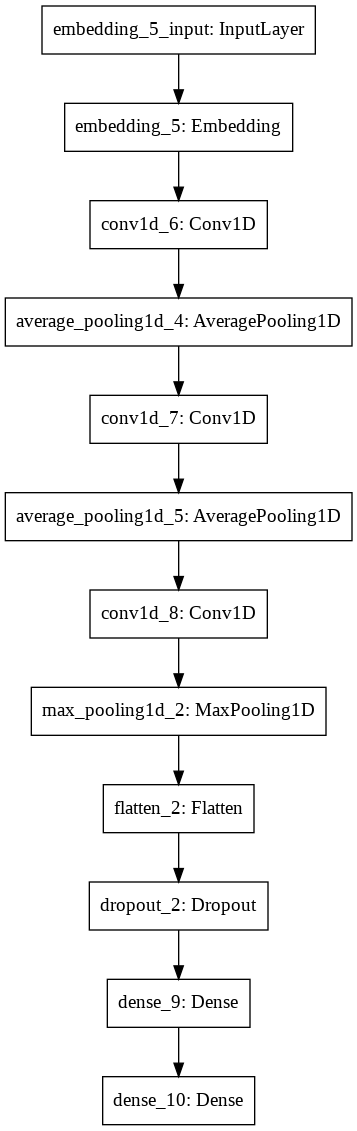

In [ ]:
keras.utils.vis_utils.plot_model(model_deep,)

In [ ]:
history_deep=train(model_deep, x_train, x_val, y_train, y_val)

Epoch 1/10
157/157 [==============================] - 41s 255ms/step - loss: 0.5299 - accuracy: 0.7125 - val_loss: 0.3408 - val_accuracy: 0.8500
Epoch 2/10
157/157 [==============================] - 40s 254ms/step - loss: 0.3388 - accuracy: 0.8542 - val_loss: 0.3360 - val_accuracy: 0.8532
Epoch 3/10
157/157 [==============================] - 41s 260ms/step - loss: 0.2701 - accuracy: 0.8895 - val_loss: 0.3094 - val_accuracy: 0.8700
Epoch 4/10
157/157 [==============================] - 41s 263ms/step - loss: 0.1818 - accuracy: 0.9330 - val_loss: 0.3044 - val_accuracy: 0.8773
Epoch 5/10
157/157 [==============================] - 41s 261ms/step - loss: 0.0988 - accuracy: 0.9670 - val_loss: 0.3761 - val_accuracy: 0.8748
Epoch 6/10
157/157 [==============================] - 41s 261ms/step - loss: 0.0610 - accuracy: 0.9803 - val_loss: 0.4658 - val_accuracy: 0.8739
Epoch 7/10
157/157 [==============================] - 41s 261ms/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.5226 - val_ac

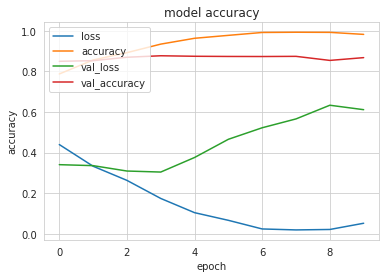

In [ ]:
legends=list(history_deep.history.keys())
for k in history_deep.history.keys():
  plt.plot(history_deep.history[k])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legends, loc='upper left')
plt.show()

In [ ]:
pred_deep_val = model_deep.predict(x=x_val, batch_size=256)

In [ ]:
from sklearn import metrics
def evaluate(expected_out, predicted_out):
    expected_categories = [np.argmax(x) for x in expected_out]
    predicted_categories = [np.argmax(x) for x in predicted_out]
    
    cm = confusion_matrix(expected_categories, predicted_categories)
    precision_score=metrics.precision_score(expected_categories, predicted_categories)
    recall=metrics.recall_score(expected_categories, predicted_categories)
    f1=metrics.f1_score(expected_categories, predicted_categories)

    print("Confusion Matrix:-\n",cm)
    print("precision:-", precision_score)
    print("Recall:-", recall)
    print("f1:-", f1)

In [ ]:
evaluate(y_val, pred_deep_val)

Confusion Matrix:-
 [[4097  828]
 [ 491 4584]]
precision:- 0.8470066518847007
Recall:- 0.9032512315270936
f1:- 0.8742252312386766
